In [1]:
import random
import gym
import time
import logging
import gym_minigrid
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess
from model.simple_stack import SimpleStack

/home/seventheli/anaconda/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.2+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [2]:
# frame channel
channel = 3
# The size of the batch to learn the Q-function
batch_size = 8
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 1
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 20000
# 20K = 30GB
# With Freq of 1/4-step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 16
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 8
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 200000000
# RMSprop learning rate
lr = 0.00025
# RMSprop gamma1
gamma1 = 0.95
# RMSprop gamma2
gamma2 = 0.95
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [3]:
env_name = 'MiniGrid-Empty-Random-6x6-v0'
env = gym.make(env_name)
num_action = 3
manualSeed = 1
mx.random.seed(manualSeed)
env_name = env_name + "-Map"

In [4]:
dqn = SimpleStack(num_action, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(dqn.collect_params(), 'RMSProp',
                        {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})
dqn.collect_params().zero_grad()

In [5]:
target_dqn = SimpleStack(num_action, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [6]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size, frame_len, channel)
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
t_record = []
moving_average_clipped = 0.
moving_average = 0.

### Train the model

In [7]:
def rew_clipper(row, history):
    counter = 0
    _ = list(reversed(history))[0]
    for i in list(reversed(history))[1:]:
        if i == _:
            counter += 1
        else:
            break
    return (row- 0.0001 * counter) * 100

def render_image(frame, render):
    if render:
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

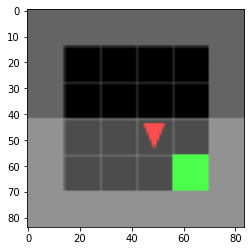

In [8]:
state, current_frame = preprocess(env.render(False), image_size, channel, frame_len, initial_state=True)
render_image(current_frame.asnumpy().transpose([1,2,0]), True)

In [ ]:
 # Whether to render Frames and show the game
_render = False
while epis_count < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    env.reset()
    next_frame = env.env.render(False)
    # next_frame = env.env.get_obs_render(env.env.gen_obs()["image"])
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    initial_state = True
    location = [env.env.agent_pos.tolist()]
    while not done:
        previous_state = state
        # show the frame
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print("annealing and learning are started tot = %.4f" % moving_average)
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)

        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        step_count = env.env.max_steps - env.env.step_count
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([step_count], ctx)]
            action = int(nd.argmax(dqn(*data), axis=1).as_in_context(mx.cpu()).asscalar())
            
        # Skip frame
        rew = 0
        for skip in range(skip_frame):
            next_frame, reward, done, _ = env.step(action)
            render_image(next_frame, _render)
            cum_clipped_reward += rew_clipper(reward, location)
            rew += reward
            location.append(env.env.agent_pos.tolist())
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew, location)
        
        # End Reward clipping
        
        # _ = env.env.get_obs_render(env.env.gen_obs()["image"])
        _ = env.env.render(False)
        state, current_frame = preprocess(_, image_size, channel, frame_len, current_state=state)
        replay_memory.push(previous_state, action, state, reward, done, step_count)
        # Train
        if frame_counter > replay_start_size and frame_counter % learning_frequency == 0:
            batch = replay_memory.sample(batch_size, ctx)
            batch_state = batch.state
            batch_state_next = batch.state_next
            batch_battery  = batch.battery
            batch_reward = batch.reward
            batch_action = batch.action.astype('uint8')
            batch_done = batch.finish
            with autograd.record():
                argmax_Q = nd.argmax(dqn(batch_state_next, batch_battery),axis = 1).astype('uint8')
                Q_sp = nd.pick(target_dqn(batch.state_next, batch.battery),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-batch_done)
                Q_s_array = dqn(batch_state, batch_battery)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_f(Q_s ,  (batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter >replay_start_size and frame_counter % target_update == 0:
            check_point = frame_counter / (target_update * 100)
            file_name = './data/target_%s_%d' % (env_name, int(check_point))
            dqn.save_parameters(file_name)
            target_dqn.load_parameters(file_name, ctx)
        if done:
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%.4f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %.4f,tot_cl = %.4f , tot = %.4f'\
                  %(epis_count,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-100:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-100:int(epis_count)-1])

epis[0],eps[1.0000],durat[145],fnum=144, cum_cl_rew = -10, cum_rew = 0.0000,tot_cl = 0.0000 , tot = 0.0000
epis[50],eps[1.0000],durat[145],fnum=5139, cum_cl_rew = -5, cum_rew = 0.0000,tot_cl = 0.0000 , tot = 0.0000
epis[100],eps[1.0000],durat[25],fnum=9034, cum_cl_rew = 84, cum_rew = 0.8500,tot_cl = 0.0000 , tot = 0.0000
epis[150],eps[1.0000],durat[63],fnum=12803, cum_cl_rew = 58, cum_rew = 0.6125,tot_cl = 45.9430 , tot = 0.4919
epis[200],eps[1.0000],durat[26],fnum=17033, cum_cl_rew = 83, cum_rew = 0.8438,tot_cl = 44.4961 , tot = 0.4773
epis[250],eps[1.0000],durat[145],fnum=21724, cum_cl_rew = -13, cum_rew = 0.0000,tot_cl = 38.4892 , tot = 0.4215
epis[300],eps[1.0000],durat[34],fnum=26099, cum_cl_rew = 78, cum_rew = 0.7937,tot_cl = 35.0093 , tot = 0.3925
epis[350],eps[1.0000],durat[145],fnum=29698, cum_cl_rew = -5, cum_rew = 0.0000,tot_cl = 42.6664 , tot = 0.4641
epis[400],eps[1.0000],durat[55],fnum=32874, cum_cl_rew = 64, cum_rew = 0.6625,tot_cl = 52.8602 , tot = 0.5564
epis[450],eps[

epis[3700],eps[0.8158],durat[27],fnum=234176, cum_cl_rew = 82, cum_rew = 0.8375,tot_cl = 66.5868 , tot = 0.6855
epis[3750],eps[0.8133],durat[18],fnum=236743, cum_cl_rew = 88, cum_rew = 0.8938,tot_cl = 67.7767 , tot = 0.6961
epis[3800],eps[0.8114],durat[13],fnum=238645, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 70.3200 , tot = 0.7197
epis[3850],eps[0.8089],durat[5],fnum=241114, cum_cl_rew = 97, cum_rew = 0.9750,tot_cl = 70.0724 , tot = 0.7175
epis[3900],eps[0.8060],durat[40],fnum=243964, cum_cl_rew = 74, cum_rew = 0.7562,tot_cl = 64.0315 , tot = 0.6621
epis[3950],eps[0.8036],durat[83],fnum=246427, cum_cl_rew = 44, cum_rew = 0.4875,tot_cl = 65.4945 , tot = 0.6746
epis[4000],eps[0.8011],durat[61],fnum=248861, cum_cl_rew = 60, cum_rew = 0.6250,tot_cl = 67.3954 , tot = 0.6919
epis[4050],eps[0.7988],durat[55],fnum=251170, cum_cl_rew = 64, cum_rew = 0.6625,tot_cl = 67.9140 , tot = 0.6969
epis[4100],eps[0.7964],durat[24],fnum=253649, cum_cl_rew = 85, cum_rew = 0.8562,tot_cl = 67.8567 , tot = 

epis[7400],eps[0.6722],durat[43],fnum=377761, cum_cl_rew = 72, cum_rew = 0.7375,tot_cl = 72.7425 , tot = 0.7457
epis[7450],eps[0.6699],durat[21],fnum=380087, cum_cl_rew = 86, cum_rew = 0.8750,tot_cl = 69.0727 , tot = 0.7105
epis[7500],eps[0.6680],durat[23],fnum=381998, cum_cl_rew = 85, cum_rew = 0.8625,tot_cl = 71.5802 , tot = 0.7332
epis[7550],eps[0.6652],durat[128],fnum=384786, cum_cl_rew = 17, cum_rew = 0.2063,tot_cl = 69.0574 , tot = 0.7101
epis[7600],eps[0.6624],durat[79],fnum=387553, cum_cl_rew = 47, cum_rew = 0.5125,tot_cl = 62.0470 , tot = 0.6466
epis[7650],eps[0.6602],durat[31],fnum=389760, cum_cl_rew = 79, cum_rew = 0.8125,tot_cl = 65.5316 , tot = 0.6794
epis[7700],eps[0.6578],durat[8],fnum=392221, cum_cl_rew = 95, cum_rew = 0.9563,tot_cl = 67.5489 , tot = 0.6977
epis[7750],eps[0.6554],durat[51],fnum=394563, cum_cl_rew = 66, cum_rew = 0.6875,tot_cl = 66.6924 , tot = 0.6894
epis[7800],eps[0.6526],durat[95],fnum=397386, cum_cl_rew = 37, cum_rew = 0.4125,tot_cl = 65.8021 , tot =

epis[11050],eps[0.5022],durat[15],fnum=547830, cum_cl_rew = 90, cum_rew = 0.9125,tot_cl = 84.8060 , tot = 0.8554
epis[11100],eps[0.5010],durat[15],fnum=548984, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 85.6112 , tot = 0.8619
epis[11150],eps[0.4999],durat[11],fnum=550144, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 84.7600 , tot = 0.8542
epis[11200],eps[0.4988],durat[19],fnum=551161, cum_cl_rew = 88, cum_rew = 0.8875,tot_cl = 85.6140 , tot = 0.8628
epis[11250],eps[0.4979],durat[31],fnum=552119, cum_cl_rew = 80, cum_rew = 0.8125,tot_cl = 87.1267 , tot = 0.8766
epis[11300],eps[0.4967],durat[26],fnum=553345, cum_cl_rew = 83, cum_rew = 0.8438,tot_cl = 85.9511 , tot = 0.8652
epis[11350],eps[0.4957],durat[41],fnum=554315, cum_cl_rew = 73, cum_rew = 0.7500,tot_cl = 85.8016 , tot = 0.8637
epis[11400],eps[0.4944],durat[43],fnum=555558, cum_cl_rew = 72, cum_rew = 0.7375,tot_cl = 85.6028 , tot = 0.8621
epis[11450],eps[0.4935],durat[15],fnum=556525, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 85.374

epis[14700],eps[0.4305],durat[13],fnum=619509, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 88.5460 , tot = 0.8899
epis[14750],eps[0.4296],durat[17],fnum=620369, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 88.8797 , tot = 0.8927
epis[14800],eps[0.4286],durat[16],fnum=621368, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 87.9120 , tot = 0.8839
epis[14850],eps[0.4278],durat[12],fnum=622198, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 87.9609 , tot = 0.8849
epis[14900],eps[0.4270],durat[18],fnum=623046, cum_cl_rew = 88, cum_rew = 0.8938,tot_cl = 89.1517 , tot = 0.8959
epis[14950],eps[0.4261],durat[16],fnum=623929, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 88.7462 , tot = 0.8919
epis[15000],eps[0.4251],durat[12],fnum=624915, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 87.7756 , tot = 0.8826
epis[15050],eps[0.4241],durat[15],fnum=625890, cum_cl_rew = 90, cum_rew = 0.9125,tot_cl = 87.1482 , tot = 0.8768
epis[15100],eps[0.4231],durat[5],fnum=626869, cum_cl_rew = 97, cum_rew = 0.9750,tot_cl = 87.1856

epis[18350],eps[0.2086],durat[43],fnum=841385, cum_cl_rew = 72, cum_rew = 0.7375,tot_cl = 31.9562 , tot = 0.4051
epis[18400],eps[0.2048],durat[103],fnum=845244, cum_cl_rew = 30, cum_rew = 0.3625,tot_cl = 40.1131 , tot = 0.4604
epis[18450],eps[0.2007],durat[10],fnum=849279, cum_cl_rew = 94, cum_rew = 0.9437,tot_cl = 42.3492 , tot = 0.4772
epis[18500],eps[0.1972],durat[50],fnum=852810, cum_cl_rew = 65, cum_rew = 0.6937,tot_cl = 41.8642 , tot = 0.4911
epis[18550],eps[0.1945],durat[11],fnum=855498, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 51.0705 , tot = 0.5822
epis[18600],eps[0.1910],durat[25],fnum=858965, cum_cl_rew = 84, cum_rew = 0.8500,tot_cl = 50.7574 , tot = 0.5847
epis[18650],eps[0.1874],durat[17],fnum=862553, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 44.9954 , tot = 0.5376
epis[18700],eps[0.1844],durat[17],fnum=865643, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 47.1316 , tot = 0.5558
epis[18750],eps[0.1819],durat[32],fnum=868106, cum_cl_rew = 79, cum_rew = 0.8063,tot_cl = 56.68

epis[22000],eps[0.1122],durat[13],fnum=937779, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 90.1769 , tot = 0.9057
epis[22050],eps[0.1116],durat[11],fnum=938407, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 91.0824 , tot = 0.9149
epis[22100],eps[0.1109],durat[16],fnum=939098, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 91.3714 , tot = 0.9176
epis[22150],eps[0.1102],durat[28],fnum=939795, cum_cl_rew = 82, cum_rew = 0.8313,tot_cl = 91.1817 , tot = 0.9147
epis[22200],eps[0.1095],durat[17],fnum=940485, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 91.0428 , tot = 0.9137
epis[22250],eps[0.1089],durat[12],fnum=941102, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 91.4340 , tot = 0.9172
epis[22300],eps[0.1082],durat[17],fnum=941814, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 91.3200 , tot = 0.9161
epis[22350],eps[0.1075],durat[12],fnum=942543, cum_cl_rew = 93, cum_rew = 0.9313,tot_cl = 90.6316 , tot = 0.9097
epis[22400],eps[0.1067],durat[15],fnum=943269, cum_cl_rew = 90, cum_rew = 0.9125,tot_cl = 90.697

epis[25650],eps[0.0321],durat[11],fnum=1017858, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 91.4151 , tot = 0.9173
epis[25700],eps[0.0314],durat[12],fnum=1018563, cum_cl_rew = 93, cum_rew = 0.9313,tot_cl = 91.1548 , tot = 0.9153
epis[25750],eps[0.0307],durat[17],fnum=1019279, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 90.8021 , tot = 0.9118
epis[25800],eps[0.0300],durat[13],fnum=1020019, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 90.4419 , tot = 0.9090
epis[25850],eps[0.0293],durat[13],fnum=1020652, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.0649 , tot = 0.9143
epis[25900],eps[0.0287],durat[13],fnum=1021305, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.7705 , tot = 0.9199
epis[25950],eps[0.0281],durat[24],fnum=1021909, cum_cl_rew = 85, cum_rew = 0.8562,tot_cl = 91.9783 , tot = 0.9218
epis[26000],eps[0.0274],durat[16],fnum=1022561, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 91.9078 , tot = 0.9214
epis[26050],eps[0.0268],durat[14],fnum=1023201, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl

epis[29250],eps[0.0100],durat[16],fnum=1064221, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 91.6653 , tot = 0.9189
epis[29300],eps[0.0100],durat[17],fnum=1064843, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 91.7615 , tot = 0.9201
epis[29350],eps[0.0100],durat[19],fnum=1065510, cum_cl_rew = 88, cum_rew = 0.8875,tot_cl = 91.7184 , tot = 0.9198
epis[29400],eps[0.0100],durat[14],fnum=1066147, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 91.5228 , tot = 0.9179
epis[29450],eps[0.0100],durat[2],fnum=1066787, cum_cl_rew = 99, cum_rew = 0.9938,tot_cl = 91.6551 , tot = 0.9193
epis[29500],eps[0.0100],durat[13],fnum=1067518, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.0717 , tot = 0.9143
epis[29550],eps[0.0100],durat[17],fnum=1068256, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 90.5095 , tot = 0.9096
epis[29600],eps[0.0100],durat[12],fnum=1068960, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 90.6299 , tot = 0.9101
epis[29650],eps[0.0100],durat[14],fnum=1069663, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl 

epis[32850],eps[0.0100],durat[18],fnum=1112618, cum_cl_rew = 89, cum_rew = 0.8938,tot_cl = 91.0780 , tot = 0.9135
epis[32900],eps[0.0100],durat[12],fnum=1113335, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 90.8632 , tot = 0.9119
epis[32950],eps[0.0100],durat[12],fnum=1114109, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 90.1361 , tot = 0.9063
epis[33000],eps[0.0100],durat[16],fnum=1114800, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 90.2908 , tot = 0.9091
epis[33050],eps[0.0100],durat[15],fnum=1115411, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 91.4910 , tot = 0.9191
epis[33100],eps[0.0100],durat[14],fnum=1116058, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 91.9535 , tot = 0.9217
epis[33150],eps[0.0100],durat[13],fnum=1116689, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.8008 , tot = 0.9201
epis[33200],eps[0.0100],durat[13],fnum=1117406, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.1572 , tot = 0.9156
epis[33250],eps[0.0100],durat[13],fnum=1118110, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl

epis[36450],eps[0.0100],durat[13],fnum=1235113, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 90.6954 , tot = 0.9122
epis[36500],eps[0.0100],durat[14],fnum=1235761, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 91.2900 , tot = 0.9170
epis[36550],eps[0.0100],durat[7],fnum=1236451, cum_cl_rew = 96, cum_rew = 0.9625,tot_cl = 91.3272 , tot = 0.9161
epis[36600],eps[0.0100],durat[11],fnum=1237170, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 90.7077 , tot = 0.9114
epis[36650],eps[0.0100],durat[12],fnum=1237843, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 90.7942 , tot = 0.9133
epis[36700],eps[0.0100],durat[14],fnum=1238540, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 91.0614 , tot = 0.9148
epis[36750],eps[0.0100],durat[14],fnum=1239233, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 90.8856 , tot = 0.9133
epis[36800],eps[0.0100],durat[12],fnum=1239851, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 91.3590 , tot = 0.9178
epis[36850],eps[0.0100],durat[12],fnum=1240512, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl 

epis[40050],eps[0.0100],durat[12],fnum=1282470, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 90.3604 , tot = 0.9078
epis[40100],eps[0.0100],durat[14],fnum=1283312, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 89.7105 , tot = 0.9029
epis[40150],eps[0.0100],durat[11],fnum=1283997, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 89.9135 , tot = 0.9046
epis[40200],eps[0.0100],durat[11],fnum=1284662, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 91.2824 , tot = 0.9158
epis[40250],eps[0.0100],durat[13],fnum=1285348, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.2083 , tot = 0.9158
epis[40300],eps[0.0100],durat[17],fnum=1286093, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 90.6557 , tot = 0.9108
epis[40350],eps[0.0100],durat[16],fnum=1286783, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 90.6677 , tot = 0.9101
epis[40400],eps[0.0100],durat[17],fnum=1287419, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 91.4861 , tot = 0.9178
epis[40450],eps[0.0100],durat[8],fnum=1288044, cum_cl_rew = 95, cum_rew = 0.9563,tot_cl 

epis[43650],eps[0.0100],durat[12],fnum=1428434, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 68.9193 , tot = 0.7668
epis[43700],eps[0.0100],durat[11],fnum=1430301, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 71.7061 , tot = 0.7746
epis[43750],eps[0.0100],durat[53],fnum=1431390, cum_cl_rew = 60, cum_rew = 0.6750,tot_cl = 78.0451 , tot = 0.8129
epis[43800],eps[0.0100],durat[16],fnum=1432716, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 83.6796 , tot = 0.8559
epis[43850],eps[0.0100],durat[12],fnum=1433872, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 80.1438 , tot = 0.8402
epis[43900],eps[0.0100],durat[63],fnum=1435032, cum_cl_rew = 57, cum_rew = 0.6125,tot_cl = 81.2586 , tot = 0.8496
epis[43950],eps[0.0100],durat[12],fnum=1436816, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 75.5920 , tot = 0.8111
epis[44000],eps[0.0100],durat[21],fnum=1437892, cum_cl_rew = 87, cum_rew = 0.8750,tot_cl = 76.2026 , tot = 0.8136
epis[44050],eps[0.0100],durat[13],fnum=1439300, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl

epis[47250],eps[0.0100],durat[12],fnum=1488269, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 91.6533 , tot = 0.9194
epis[47300],eps[0.0100],durat[13],fnum=1488907, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.9439 , tot = 0.9220
epis[47350],eps[0.0100],durat[18],fnum=1489521, cum_cl_rew = 89, cum_rew = 0.8938,tot_cl = 91.9569 , tot = 0.9221
epis[47400],eps[0.0100],durat[17],fnum=1490175, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 91.8759 , tot = 0.9212
epis[47450],eps[0.0100],durat[5],fnum=1490864, cum_cl_rew = 97, cum_rew = 0.9750,tot_cl = 91.2258 , tot = 0.9155
epis[47500],eps[0.0100],durat[8],fnum=1491466, cum_cl_rew = 95, cum_rew = 0.9563,tot_cl = 91.5861 , tot = 0.9188
epis[47550],eps[0.0100],durat[16],fnum=1492132, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 91.8408 , tot = 0.9208
epis[47600],eps[0.0100],durat[13],fnum=1492780, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.5573 , tot = 0.9183
epis[47650],eps[0.0100],durat[16],fnum=1493414, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl =

epis[50850],eps[0.0100],durat[17],fnum=1534899, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 92.1933 , tot = 0.9239
epis[50900],eps[0.0100],durat[2],fnum=1535532, cum_cl_rew = 99, cum_rew = 0.9938,tot_cl = 91.9532 , tot = 0.9219
epis[50950],eps[0.0100],durat[14],fnum=1536145, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 91.9567 , tot = 0.9220
epis[51000],eps[0.0100],durat[18],fnum=1536815, cum_cl_rew = 89, cum_rew = 0.8938,tot_cl = 91.7637 , tot = 0.9208
epis[51050],eps[0.0100],durat[13],fnum=1537434, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 91.6593 , tot = 0.9196
epis[51100],eps[0.0100],durat[15],fnum=1538034, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 92.1945 , tot = 0.9239
epis[51150],eps[0.0100],durat[16],fnum=1538653, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 92.1588 , tot = 0.9236
epis[51200],eps[0.0100],durat[16],fnum=1539272, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 92.0211 , tot = 0.9224
epis[51250],eps[0.0100],durat[13],fnum=1539896, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl 

epis[54450],eps[0.0100],durat[78],fnum=1692683, cum_cl_rew = 29, cum_rew = 0.5188,tot_cl = 33.1364 , tot = 0.4647
epis[54500],eps[0.0100],durat[145],fnum=1696642, cum_cl_rew = -23, cum_rew = 0.0000,tot_cl = 41.7661 , tot = 0.5428
epis[54550],eps[0.0100],durat[17],fnum=1699312, cum_cl_rew = 89, cum_rew = 0.9000,tot_cl = 44.6682 , tot = 0.5555
epis[54600],eps[0.0100],durat[4],fnum=1700623, cum_cl_rew = 98, cum_rew = 0.9812,tot_cl = 66.8687 , tot = 0.7308
epis[54650],eps[0.0100],durat[13],fnum=1701499, cum_cl_rew = 91, cum_rew = 0.9250,tot_cl = 83.3665 , tot = 0.8572
epis[54700],eps[0.0100],durat[22],fnum=1703100, cum_cl_rew = 86, cum_rew = 0.8688,tot_cl = 80.7966 , tot = 0.8451
epis[54750],eps[0.0100],durat[5],fnum=1704154, cum_cl_rew = 97, cum_rew = 0.9750,tot_cl = 78.7725 , tot = 0.8317
epis[54800],eps[0.0100],durat[15],fnum=1705288, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 84.1379 , tot = 0.8614
epis[54850],eps[0.0100],durat[16],fnum=1706855, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl

epis[58050],eps[0.0100],durat[12],fnum=1756559, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 89.9948 , tot = 0.9086
epis[58100],eps[0.0100],durat[10],fnum=1757319, cum_cl_rew = 94, cum_rew = 0.9437,tot_cl = 90.8115 , tot = 0.9134
epis[58150],eps[0.0100],durat[16],fnum=1758169, cum_cl_rew = 90, cum_rew = 0.9062,tot_cl = 88.7265 , tot = 0.8998
epis[58200],eps[0.0100],durat[13],fnum=1758968, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 88.3417 , tot = 0.8969
epis[58250],eps[0.0100],durat[25],fnum=1759837, cum_cl_rew = 84, cum_rew = 0.8500,tot_cl = 88.5738 , tot = 0.8961
epis[58300],eps[0.0100],durat[13],fnum=1760673, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 88.1061 , tot = 0.8938
epis[58350],eps[0.0100],durat[15],fnum=1761459, cum_cl_rew = 91, cum_rew = 0.9125,tot_cl = 88.8891 , tot = 0.8984
epis[58400],eps[0.0100],durat[23],fnum=1762265, cum_cl_rew = 85, cum_rew = 0.8625,tot_cl = 89.6518 , tot = 0.9012
epis[58450],eps[0.0100],durat[7],fnum=1763098, cum_cl_rew = 96, cum_rew = 0.9625,tot_cl 

epis[61650],eps[0.0100],durat[14],fnum=1812721, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 92.0131 , tot = 0.9224
epis[61700],eps[0.0100],durat[12],fnum=1813604, cum_cl_rew = 92, cum_rew = 0.9313,tot_cl = 89.5534 , tot = 0.9067
epis[61750],eps[0.0100],durat[13],fnum=1814768, cum_cl_rew = 92, cum_rew = 0.9250,tot_cl = 84.9305 , tot = 0.8721
epis[61800],eps[0.0100],durat[14],fnum=1815595, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 86.1125 , tot = 0.8766
epis[61850],eps[0.0100],durat[14],fnum=1816241, cum_cl_rew = 91, cum_rew = 0.9187,tot_cl = 90.3639 , tot = 0.9080
epis[61900],eps[0.0100],durat[27],fnum=1817074, cum_cl_rew = 82, cum_rew = 0.8375,tot_cl = 90.4196 , tot = 0.9081
epis[61950],eps[0.0100],durat[9],fnum=1818083, cum_cl_rew = 94, cum_rew = 0.9500,tot_cl = 87.6906 , tot = 0.8847
epis[62000],eps[0.0100],durat[11],fnum=1819241, cum_cl_rew = 93, cum_rew = 0.9375,tot_cl = 84.3972 , tot = 0.8608
epis[62050],eps[0.0100],durat[2],fnum=1820038, cum_cl_rew = 99, cum_rew = 0.9938,tot_cl =

### Plot the overall performace

Running after 107253 number of episodes


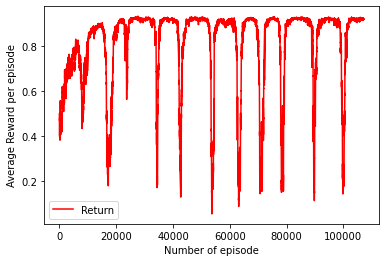

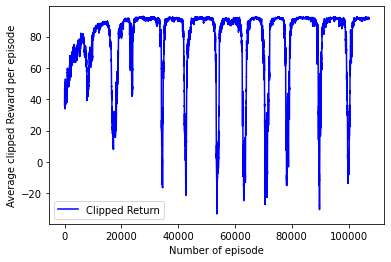

In [10]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Grid_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Grid_Clipped.png')